## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

rt = np.array(response[ResponseTime])

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ReactionTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time for an individual subject, showing all 3 difficulty conditions in a single graph.
 
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


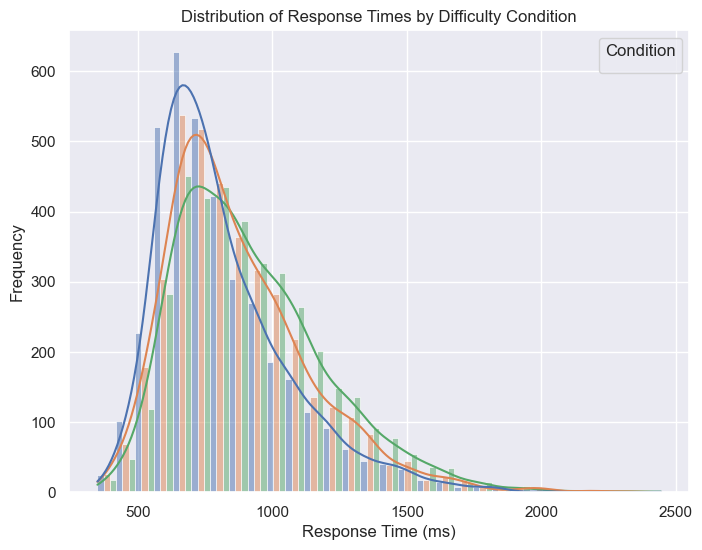

In [21]:
#use seaborn to make it easier 
#do all of the data not one subject 

response = pd.read_csv("ResponseTimeData.csv")

plt.figure(figsize=(8, 6))
sns.histplot(
    data = response,
    x = "ResponseTime",
    hue = "Condition",
    bins=30,
    hue_order = ['Easy', 'Medium', 'Hard'],
    kde=True,
    multiple='dodge'
    
)

plt.xlabel("Response Time (ms)")
plt.ylabel("Frequency")
plt.title("Distribution of Response Times by Difficulty Condition")
plt.legend(title="Condition")

plt.show()

In [24]:
accuracy = response['Correct'].mean()
print(f'Overall accuracy is {accuracy*100:.2f}%')

mean_rt = response['ResponseTime'].mean()
print(f'Overall mean response time is {mean_rt:.1f} ms')

Overall accuracy is 78.60%
Overall mean response time is 868.7 ms


In [25]:
#convert into arrays
mean_rt_by_condition = response.groupby('Condition')['ResponseTime'].mean()
mean_acc_by_condition = response.groupby('Condition')['Correct'].mean()
print('Mean Response Time by Condition:')
print(mean_rt_by_condition)
print('Mean Accuracy by Condition:')
print(mean_acc_by_condition)

Mean Response Time by Condition:
Condition
Easy      812.957842
Hard      920.328282
Medium    871.684659
Name: ResponseTime, dtype: float64
Mean Accuracy by Condition:
Condition
Easy      0.884263
Hard      0.671462
Medium    0.804236
Name: Correct, dtype: float64


b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

<function matplotlib.pyplot.show(close=None, block=None)>

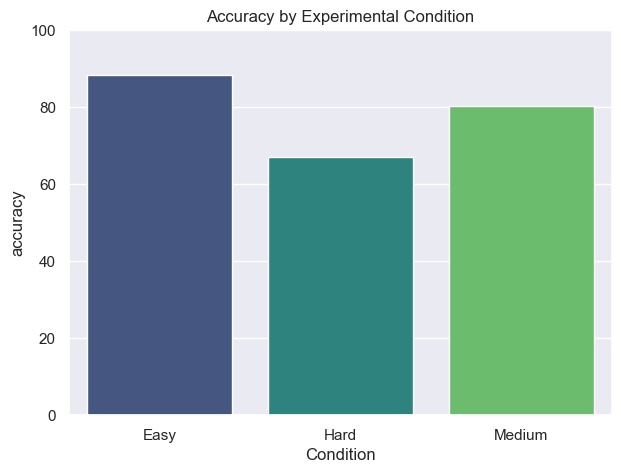

In [26]:
accuracy = response.groupby("Condition")["Correct"].mean().reset_index()

accuracy["Accuracy(%)"] = accuracy["Correct"]*100

plt.figure(figsize=(7,5))
sns.barplot(
    data = accuracy,
    x = "Condition",
    y = "Accuracy(%)",
    palette="viridis"
    
)

plt.title("Accuracy by Experimental Condition")
plt.xlabel("Condition")
plt.ylabel("accuracy")
plt.ylim(0,100)

plt.show

c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

Index(['Unnamed: 0', 'Subject', 'Condition', 'Correct', 'ResponseTime'], dtype='object')


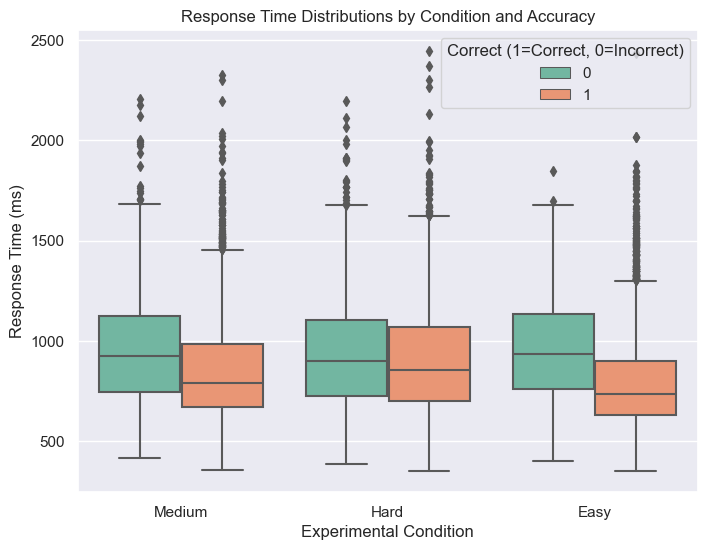

In [28]:
print(response.columns)

# Create the boxplot
plt.figure(figsize=(8,6))
sns.boxplot(
    data=response,
    x="Condition",   # x-axis: Easy, Medium, Hard
    y="ResponseTime",            # y-axis: Response time
    hue="Correct",               # separate by correctness
    palette="Set2"               # nice color palette
)

# Add labels and title
plt.title("Response Time Distributions by Condition and Accuracy")
plt.xlabel("Experimental Condition")
plt.ylabel("Response Time (ms)")

# Adjust legend
plt.legend(title="Correct (1=Correct, 0=Incorrect)")

plt.show()

d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


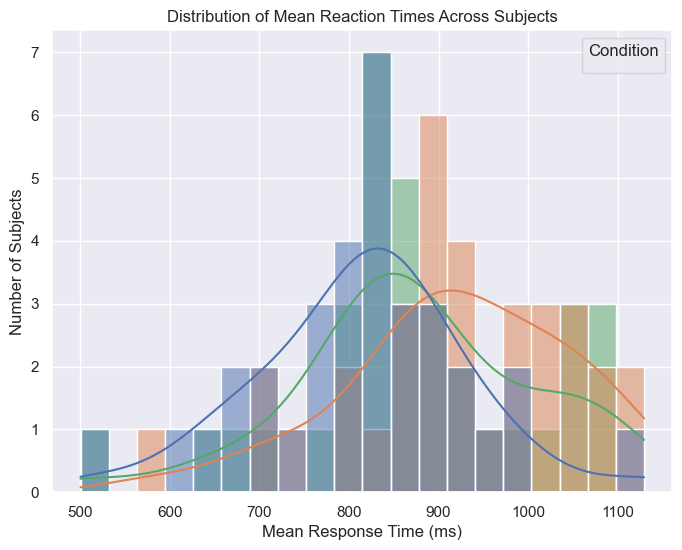

In [31]:
mean_rt = (
    response.groupby(["Subject", "Condition"])["ResponseTime"]
      .mean()
      .reset_index()
)

# --- Step 2: Plot histogram of mean RTs across subjects ---
plt.figure(figsize=(8,6))
sns.histplot(
    data=mean_rt,
    x="ResponseTime",
    hue="Condition",  # separate by condition
    kde=True,
    bins=20,
    alpha=0.5
)

# --- Step 3: Labels and title ---
plt.title("Distribution of Mean Reaction Times Across Subjects")
plt.xlabel("Mean Response Time (ms)")
plt.ylabel("Number of Subjects")
plt.legend(title="Condition")

plt.show()

In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [50]:
correct_trials = response[response["Correct"]==1]
rt_data = correct_trials["ResponseTime"].values

params = [.5, 1.0, 300] #feel like I should have different paramenters
def shiftedwald(params, rt_data):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
    
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 

    a = rt_data-theta

    z = alpha/np.sqrt(2*np.pi*(a**3))
    w = ((np.abs(alpha-gamma*a))**2)/(2*a)
    f = z*np.exp(-w)
    return f

shiftWald = shiftedwald(params, rt_data)
print(shiftWald)

[1.18672031e-29 1.18672031e-29 1.04384393e-29 ... 5.86669224e-56
 3.53555141e-56 7.76196003e-79]


### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [44]:
from scipy.stats import invgauss

def negloglikeWald(params):
    ##MAKE USE OF DATA, CORRECT, AND CONDITION LABELS
    ##DECISION MAKING LECTURE
    ''' written with params containing gamma, alpha, theta in that order.  Assumes data is in the variable data'''
    
    mu = params [0]
    lam = params[1]
    shift = params[2]

    if lam <=0 or mu <= 0:
        return np.inf
    
    shifted_data = rt_data-shift

    if np.any(shifted_data <=0):
        return np.inf
    
    pdf_vals = invgauss(mu / lam, scale=lam).pdf(shifted_data)

    pdf_vals = np.maximum(pdf_vals, 1e-12)

    negloglike = -np.sum(np.log(pdf_vals))
    
    return negloglike 


rt_data = correct_trials["ResponseTime"].values
params = [.5, 1.0, 300] #feel like I should have different paramenters
result = negloglikeWald(params)
print(result)

251580.4472605294


### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ReactionTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution. 
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

In [73]:
from scipy.optimize import minimize
print(response.columns)

paramfit = dict()

rt = response["ResponseTime"].values
correct = response["Correct"].values
condition = response["Condition"].values
condition_labels = response["Condition"].unique()

rt_data = rt[(correct == 1)]

def negloglikeWald(params, rt_data):
    mu = params[0]
    lam = params[1]
    shift = params[2]

    if mu <= 0 or lam <=0 or shift <=0:
        return 1e10
    
    shifted = rt_data - shift

    if np.any(shifted<=0):
        return 1e10
    
    pdf_values = invgauss(mu / lam , scale = lam).pdf(shifted)
    pdf_values = np.maximum(pdf_values, 1e-12)

    return -np.sum(np.log(pdf_values))


data_all = rt[correct==1]

x0 = [1.0, 2.0, 300]
bnds = (
    (0.01, np.inf), 
    (0.01, np.inf),
    (0.01, np.min(data_all)*.9)) #AI says this is wrong, but I'm going to leave it for now

paramfit={}
paramfit['All'] = minimize(
    negloglikeWald, 
    x0=x0, 
    args = (data_all,),
    bounds = bnds, 
    options={'maxfun':100000})

#fit model
for c in response["Condition"].unique(): 
    data = rt[(correct ==1) & (condition ==c)]
    if len(data)==0:
        print(f"Skipping {c} - no data found")

    bnds_cond = (
        (0.01, np.inf),
        (0.01, np.inf),
        (0.01, np.min(data)*.9)
    )

    res = minimize(
        negloglikeWald, 
        [0.01, 100, 200],
        args = (data,) ,
        bounds = bnds_cond, 
        options={'maxfun':100000})
    paramfit[c] = res


results = pd.DataFrame([
    {"Model": k, "mu": v.x[0], "lambda": v.x[1], "shift": v.x[2], "NegLogLik": v.fun}
    for k, v in paramfit.items()
])
print(results)
print(response["Condition"].unique())

Index(['Unnamed: 0', 'Subject', 'Condition', 'Correct', 'ResponseTime'], dtype='object')
    Model    mu  lambda  shift      NegLogLik
0     All  1.00     2.0  300.0  251580.447261
1  Medium  0.01   100.0  200.0   86042.999755
2    Hard  0.01   100.0  200.0   72227.489197
3    Easy  0.01   100.0  200.0   93309.958308
['Medium' 'Hard' 'Easy']


### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

In [75]:
aic = dict()

aic = dict()
aic['All'] = 2 * 3 + 2 * paramfit['All'].fun
aic['Easy'] = 2 * 3 + 2 * paramfit['Easy'].fun
aic['Medium'] = 2 * 3 + 2 * paramfit['Medium'].fun
aic['Hard'] = 2 * 3 + 2 * paramfit['Hard'].fun

aic['Three'] = aic['Easy'] + aic['Medium'] + aic['Hard']

print(aic)

print("AIC suggests using Model A from 1distribution is preferred")

{'All': 503166.8945210588, 'Easy': 186625.91661698138, 'Medium': 172091.99951000296, 'Hard': 144460.97839407442, 'Three': 503178.89452105877}
AIC suggests using Model A from 1distribution is preferred


### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions. 

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

In [76]:
import numpy as np
from scipy.stats import invgauss

def negloglikeWald_driftVary(params, rt_data, condition_labels):
    """
    Negative log likelihood for a model where:
      - Drift rate (gamma) varies by condition (Easy, Medium, Hard)
      - Boundary (alpha) and Non-decision time (theta) are shared across conditions

    Parameters
    ----------
    params : list or array
        [gamma_easy, gamma_medium, gamma_hard, alpha, theta]
    rt_data : array-like
        Reaction time data for all trials
    condition_labels : array-like
        Array of condition labels corresponding to each RT (e.g. 'Easy', 'Medium', 'Hard')

    Returns
    -------
    negloglike : float
        The negative log likelihood of the data under the model
    """

    # unpack parameters
    gamma_easy, gamma_medium, gamma_hard, alpha, theta = params

    # ensure all params are positive (if not, return large penalty)
    if np.any(np.array(params) <= 0):
        return np.inf

    total_loglike = 0.0

    # Loop through each condition
    for cond, gamma in zip(["Easy", "Medium", "Hard"], [gamma_easy, gamma_medium, gamma_hard]):
        # select data for this condition
        rt_cond = rt_data[condition_labels == cond]

        # shift RTs by non-decision time
        shifted_rt = rt_cond - theta
        shifted_rt = shifted_rt[shifted_rt > 0]  # only valid times

        # compute pdf for shifted Wald (inverse Gaussian) distribution
        mu = alpha / gamma
        pdf_vals = invgauss(mu / alpha, scale=alpha**2 / gamma).pdf(shifted_rt)

        # avoid log(0)
        pdf_vals[pdf_vals <= 1e-10] = 1e-10

        # accumulate log-likelihood
        total_loglike += np.sum(np.log(pdf_vals))

    # return NEGATIVE log likelihood
    return -total_loglike

from scipy.optimize import minimize

# initial guesses
x0 = [1.0, 1.0, 1.0, 100.0, 200.0]  # γ_easy, γ_medium, γ_hard, α, θ

# bounds: all parameters positive
bnds = [(0.01, np.inf)] * 5

# fit the model
res = minimize(
    negloglikeWald_driftVary,
    x0=x0,
    args=(rt, condition),  # rt = all RT data, condition = corresponding labels
    bounds=bnds,
    options={'maxfun': 100000}
)

print(res)



  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 79862.0368686946
        x: [ 7.254e+00  6.943e+00  6.711e+00  1.839e+02  1.702e+02]
      nit: 36
      jac: [ 2.285e-01 -1.499e-01 -3.783e-02 -1.455e-03  1.455e-03]
     nfev: 234
     njev: 39
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

In [78]:
k = 5  # number of parameters
AIC_driftVary = 2 * k + 2 * res.fun
print("AIC (Drift Varies Only):", AIC_driftVary)


paramfit['DriftVary'] = res
{'All': ..., 'Easy': ..., 'Medium': ..., 'Hard': ..., 'DriftVary': ...}
import pandas as pd

results = []

for name, fit in paramfit.items():
    n_params = len(fit.x)
    results.append({
        "Model": name,
        **{f"Param{i+1}": val for i, val in enumerate(fit.x)},
        "NegLogLik": fit.fun,
        "k": n_params,
        "AIC": 2 * n_params + 2 * fit.fun
    })

results_df = pd.DataFrame(results)
print(results_df)


AIC_three = (
    2 * 3 + 2 * paramfit['Easy'].fun +
    2 * 3 + 2 * paramfit['Medium'].fun +
    2 * 3 + 2 * paramfit['Hard'].fun
)

results_df.loc[len(results_df)] = {
    "Model": "ThreeCombined",
    "NegLogLik": (paramfit['Easy'].fun + paramfit['Medium'].fun + paramfit['Hard'].fun),
    "k": 9,
    "AIC": AIC_three
}

cols = ["Model", "NegLogLik", "k", "AIC"]
print(results_df[cols].sort_values("AIC").reset_index(drop=True))


AIC (Drift Varies Only): 159734.0737373892
       Model    Param1     Param2      Param3      NegLogLik  k  \
0        All  1.000000    2.00000  300.000000  251580.447261  3   
1     Medium  0.010000  100.00000  200.000000   86042.999755  3   
2       Hard  0.010000  100.00000  200.000000   72227.489197  3   
3       Easy  0.010000  100.00000  200.000000   93309.958308  3   
4  DriftVary  7.254473    6.94334    6.710716   79862.036869  5   

             AIC      Param4      Param5  
0  503166.894521         NaN         NaN  
1  172091.999510         NaN         NaN  
2  144460.978394         NaN         NaN  
3  186625.916617         NaN         NaN  
4  159734.073737  183.870833  170.213761  
           Model      NegLogLik  k            AIC
0           Hard   72227.489197  3  144460.978394
1      DriftVary   79862.036869  5  159734.073737
2         Medium   86042.999755  3  172091.999510
3           Easy   93309.958308  3  186625.916617
4            All  251580.447261  3  503166.894

### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   